In [5]:
import numpy as np
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import salvus.mesh
import salvus.mesh.layered_meshing as lm

import salvus.namespace as sn
import matplotlib.pyplot as plt

In [6]:

CENTRAL_FREQUENCY = 1.5e6  # MHz
assert CENTRAL_FREQUENCY >= 1.5e6
x0, x1 = 0.0, 0.005
y0, y1 = 0.0, 0.005

domain = sn.domain.dim2.BoxDomain(x0=x0, x1=x1, y0=y0, y1=y1)


# acoustic material
homogeneous_model = lm.LayeredModel(
    [
        sn.material.acoustic.Velocity.from_params(rho=2600.0, vp=5000.0),
    ]
)

homogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    homogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=False,
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh_homogeneous = lm.mesh_from_domain(
    domain=domain,
    model=homogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=3
    ),
)


Text(0.5, 1.0, 'XY')

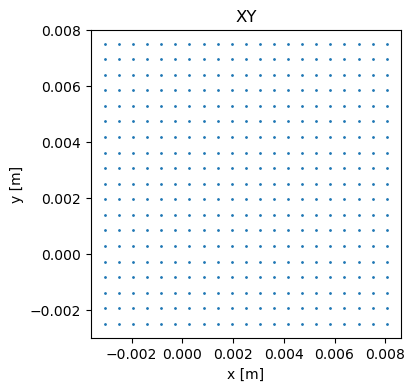

In [7]:
fig = plt.figure(figsize=(4, 4))
ax1 = fig.subplots(1, 1)

ax1.scatter(mesh_homogeneous.points[:, 0], mesh_homogeneous.points[:, 1], s=1)
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")
ax1.set_title("XY")

In [8]:
mesh_homogeneous

In [9]:
mesh_homogeneous.connectivity


array([[  0,  19,   1,  20],
       [ 19,  38,  20,  39],
       [ 38,  57,  39,  58],
       ...,
       [340, 359, 341, 360],
       [359, 378, 360, 379],
       [378, 397, 379, 398]])

In [10]:
mesh_homogeneous.points

array([[-0.00305556, -0.0025    ],
       [-0.00305556, -0.00194444],
       [-0.00305556, -0.00138889],
       [-0.00305556, -0.00083333],
       [-0.00305556, -0.00027778],
       [-0.00305556,  0.00027778],
       [-0.00305556,  0.00083333],
       [-0.00305556,  0.00138889],
       [-0.00305556,  0.00194444],
       [-0.00305556,  0.0025    ],
       [-0.00305556,  0.00305556],
       [-0.00305556,  0.00361111],
       [-0.00305556,  0.00416667],
       [-0.00305556,  0.00472222],
       [-0.00305556,  0.00527778],
       [-0.00305556,  0.00583333],
       [-0.00305556,  0.00638889],
       [-0.00305556,  0.00694444],
       [-0.00305556,  0.0075    ],
       [-0.0025    , -0.0025    ],
       [-0.0025    , -0.00194444],
       [-0.0025    , -0.00138889],
       [-0.0025    , -0.00083333],
       [-0.0025    , -0.00027778],
       [-0.0025    ,  0.00027778],
       [-0.0025    ,  0.00083333],
       [-0.0025    ,  0.00138889],
       [-0.0025    ,  0.00194444],
       [-0.0025    ,

In [11]:
mesh_homogeneous.shape_order

1

In [22]:
mesh_homogeneous.element_nodal_fields['VP'].shape

(360, 4)

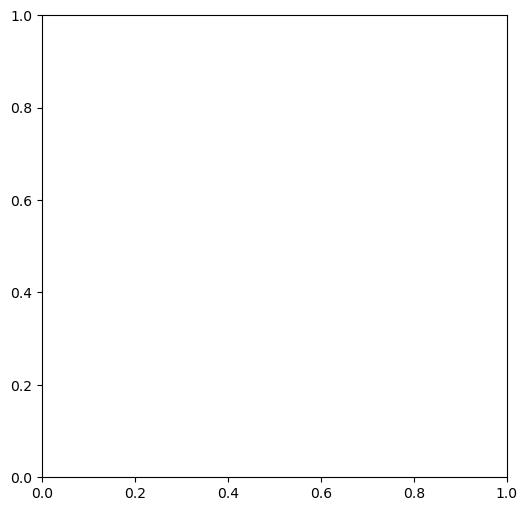

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import microstructpy.geometry as msp_geometry
import microstructpy.seeding as msp_seeding
import microstructpy.meshing as msp_meshing

# --- Domain: Circle
domain = msp_geometry.Circle(radius=1.0)

# --- Seed points
factory = msp_seeding.Seed.factory
n = 50
seeds = msp_seeding.SeedList([factory('circle', r=0.01) for _ in range(n)])
seeds.position(domain)

# --- Generate polygonal mesh
pmesh = msp_meshing.PolyMesh.from_seeds(seeds, domain)

# --- Color by polygon area
areas = np.array(pmesh.volumes)
norm = mcolors.Normalize(vmin=areas.min(), vmax=areas.max())
colors = [(0, (0, 0, 1)), (0.5, (1, 1, 1)), (1, (1, 0, 0))]
cmap = mcolors.LinearSegmentedColormap.from_list('area_cmap', colors)

# --- Plot
fig, ax = plt.subplots(figsize=(6, 6))
# for poly, area in zip(pmesh.polygons, areas):
#     x, y = poly.exterior.xy
#     ax.fill(x, y, color=cmap(norm(area)), edgecolor='black', linewidth=0.5)



In [4]:
from __future__ import division

import os

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance

import microstructpy as msp

# Create domain
domain = msp.geometry.Circle()

# Create list of seed points
factory = msp.seeding.Seed.factory
n = 200
seeds = msp.seeding.SeedList([factory('circle', r=0.007) for i in range(n)])

# Position seeds according to Mitchell's Best Candidate Algorithm
np.random.seed(0)

lims = np.array(domain.limits) * (1 - 1e-5)
centers = np.zeros((n, 2))

for i in range(n):
    f = np.random.rand(i + 1, 2)
    pts = f * lims[:, 0] + (1 - f) * lims[:, 1]
    try:
        min_dists = distance.cdist(pts, centers[:i]).min(axis=1)
        i_max = np.argmax(min_dists)
    except ValueError:  # this is the case when i=0
        i_max = 0
    centers[i] = pts[i_max]
    seeds[i].position = centers[i]

# Create Voronoi diagram
pmesh = msp.meshing.PolyMesh.from_seeds(seeds, domain)

# Set colors based on area
areas = pmesh.volumes
std_area = domain.area / n
min_area = min(areas)
max_area = max(areas)
cell_colors = np.zeros((n, 3))
for i in range(n):
    if areas[i] < std_area:
        f_red = (areas[i] - min_area) / (std_area - min_area)
        f_green = (areas[i] - min_area) / (std_area - min_area)
        f_blue = 1
    else:
        f_red = 1
        f_green = (max_area - areas[i]) / (max_area - std_area)
        f_blue = (max_area - areas[i]) / (max_area - std_area)
    cell_colors[i] = (f_red, f_green, f_blue)

# Create colorbar
vs = (std_area - min_area) / (max_area - min_area)
colors = [(0, (0, 0, 1)), (vs, (1, 1, 1)), (1, (1, 0, 0))]
cmap = mpl.colors.LinearSegmentedColormap.from_list('area_cmap', colors)
norm = mpl.colors.Normalize(vmin=min_area, vmax=max_area)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = plt.colorbar(sm, ticks=[min_area, std_area, max_area], ax=plt.gca(),
                  orientation='horizontal', fraction=0.046, pad=0.08)
cb.set_label('Cell Area')

# Plot Voronoi diagram and seed points
pmesh.plot(edgecolors='k', facecolors=cell_colors)
seeds.plot(edgecolors='k', facecolors='none')

plt.axis('square')
plt.xlim(domain.limits[0])
plt.ylim(domain.limits[1])

# Save diagram
# file_dir = os.path.dirname(os.path.realpath(__file__))
# filename = os.path.join(file_dir, 'uniform_seeding/voronoi_diagram.png')
# dirs = os.path.dirname(filename)
# if not os.path.exists(dirs):
    # os.makedirs(dirs)
# plt.savefig(filename, bbox_inches='tight', pad_inches=0)

AssertionError: {3, 4, 133, 135, 9, 140, 15, 145, 20, 23, 24, 30, 31, 159, 160, 34, 35, 161, 165, 40, 172, 173, 46, 175, 176, 52, 183, 184, 58, 60, 191, 68, 73, 76, 77, 79, 80, 82, 88, 89, 90, 94, 97, 99, 101, 102, 104, 112, 113, 114, 116, 118, 126}

In [5]:
pmesh

PolyMesh([array([-0.21436551,  0.40167584]), array([-0.26267935,  0.22008668]), array([-0.32962138,  0.55252768]), array([-0.34408786,  0.56887544]), array([-0.66121875,  0.52398898]), array([-0.62530075,  0.41432946]), array([-0.58936038,  0.38636657]), array([-0.26809215,  0.2147428 ]), array([-0.58511372,  0.38377078]), array([ 0.11296836, -0.50700281]), array([ 0.11262612, -0.4879617 ]), array([-0.14062233, -0.32176245]), array([-0.22566224, -0.15439011]), array([-0.1763254 , -0.11096263]), array([ 0.00183397, -0.18628299]), array([ 0.38604464, -0.51647912]), array([ 0.56166547, -0.82736443]), array([ 0.03295039, -0.62218231]), array([ 0.11582114, -0.51885992]), array([ 0.03703987, -0.73748516]), array([ 0.14973861, -0.98872562]), array([0.65634938, 0.25428974]), array([0.8783628 , 0.47799456]), array([0.53851304, 0.25630348]), array([0.37651536, 0.34467772]), array([0.37174686, 0.33474656]), array([0.85261591, 0.52253815]), array([0.37343672, 0.32588838]), array([0.00081529, 0.255